The goal of this notebook is to showcase the capabilities of a new python library (xee) that was released recently and to built up on xarray and how it can be used for analyzing EarthEngine (and in general, geospatial) datasets: https://github.com/google/Xee

For more information about xarray and how to use it for climate data analysis, check out this tutorial that I had put together about 2 years ago: https://www.linkedin.com/pulse/python-climate-data-analysis-tutorial-code-ali-ahmadalipour

The requirements to run this notebook are provided in requirements.in

Develoed by: Ali Ahmadalipour,
January 2024

# 1. Imports and configuration:

In [1]:
import cartopy.crs
import cartopy.feature as cfeature
import dask.distributed
import ee
import google.auth.compute_engine
import matplotlib.pyplot as plt
import xarray as xr

In [ ]:
# Starting dask for multi-processing:
client = dask.distributed.Client(n_workers=4)
client

I'm using a normal machine with 4 cpus and about 16GB of RAM, but you'll see later that our memory usage never exceeded 8GB (just in case you're worried if you can replicate this analysis on your machine).

If you want to learn more about dask, here's a good tutorial for it:
https://training.talkpython.fm/courses/introduction-to-scaling-python-and-pandas-with-dask

In [3]:
# initialize Earth Engine:
# You need to have an active EE acount for this to work.
credentials = google.auth.compute_engine.Credentials()
ee.Initialize(credentials,
              opt_url='https://earthengine-highvolume.googleapis.com')

# 2. Data analysis:

Let's import ERA5-Land daily data for air temperature across the Contiguous US since 2000, change the projection to WGS84 (aka EPSG4326) and regrid the data to 0.2 degrees. The original data is at 0.25 degree spatial resolution and hourly temporal resolution, and can be found at this link:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview.

Here, we import the data from Earth Engine (EE) data catalogue. On EE, you can find the description for all the bands in the following link:
https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR#bands

In [ ]:
# From the above EE link, we can find the name of the desired band and use
# it here (temperature_2m for our case).
ic = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(
    '2000-01-01', '2023-12-31').select('temperature_2m')
# Another way to do the selection is to not select any band in ic, and then use
# xarray to select the desired variable.
region = ee.Geometry.Rectangle(-130, 25, -60, 50)
ds = xr.open_dataset(ic,
                     engine='ee',
                     crs='EPSG:4326',
                     scale=0.2,
                     geometry=region)

In [5]:
ds

<xarray.Dataset>
Dimensions:         (time: 8763, lon: 350, lat: 152)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2023-12-28
  * lon             (lon) float32 -129.9 -129.7 -129.5 ... -60.5 -60.3 -60.1
  * lat             (lat) float32 55.4 55.2 55.0 54.8 ... 25.8 25.6 25.4 25.2
Data variables:
    temperature_2m  (time, lon, lat) float64 ...
Attributes:
    crs:      EPSG:4326

There we go! we can instantly see the metadata of the entire dataset, and now we
can fine tune our selection or change anything if necessary.

In [6]:
# Note that the ERA5 data is in Kelvin and we'll convert it to Farenheight. If
# we want to convert all the data at first, we can do so using the following
# line. However, that means that we'll read the entire data in the beginning and
# convert it, which is not optimum. Thus, we'll first do the analysis and
# whenever needed, we'll convert the unit then.
# ds.__setitem__('temperature_2m',(ds.temperature_2m - 273.15)* 1.8 + 32)

## 2.1. A simple analysis and visualization:

For this section, let's do a simple analysis. Let's calculate the climatology (long-term average temperature) for each month. Then, let's plot the result for January.

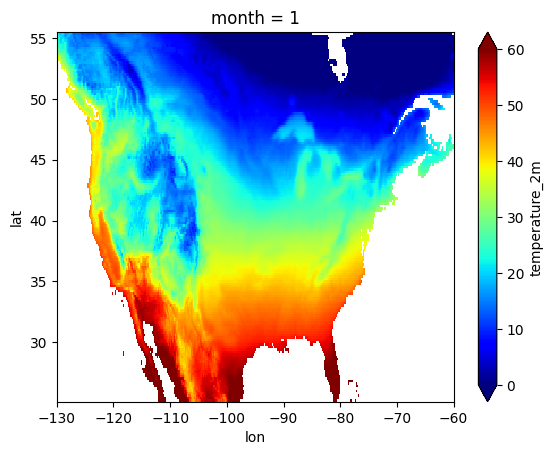

In [7]:
ds_mon = ds.groupby(ds.time.dt.month).mean('time')
ds_jan = ds_mon.sel(month=1)
ds_jan.__setitem__('temperature_2m',(ds_jan.temperature_2m - 273.15)* 1.8 + 32)
ds_jan.temperature_2m.plot(x='lon', y='lat', vmin=0, vmax=60, cmap='jet')

There we have it. The long-term mean temperature in January during 2000-2023. That analysis took about 60 seconds and less than 8GB of RAM and no raw data was downloaded! As you can see, the plot is really basic and it's not the best presentation. In the last part, We'll use Cartopy and we'll add a lot more features to it to make the figure much more interesting.

## 2.2. Extracting point data:

Let's leverage xarray functionalities and extract timeseries of temperature data for Dallas, TX in February.

In [8]:
ds_dallas = ds.sel(lat=32.802, lon=-96.782, method='nearest').where(
  ds.time.dt.month==2, drop=True)
ds_dallas.__setitem__('temperature_2m',(ds_dallas.temperature_2m-273.15)*1.8+32)

Now let's plot the daily values for each year all in one plot (stacked on top of each other):

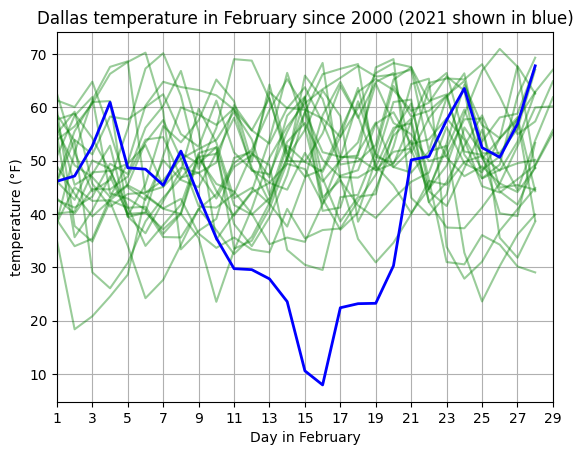

In [9]:
for yr in range(2000,2023):
  da_sel = ds_dallas.temperature_2m.where(ds_dallas.time.dt.year==yr, drop=True)
  if yr == 2021:
    plt.plot(da_sel.time.dt.day, da_sel, color='b', linewidth=2)
  else:
    plt.plot(da_sel.time.dt.day, da_sel, color='g', alpha=.4)
plt.grid()
plt.xlim([1,29])
plt.xlabel('Day in February')
plt.xticks(ticks=range(1,30,2))
plt.ylabel('temperature (°F)')
plt.title('Dallas temperature in February since 2000 (2021 shown in blue)');

## 2.3. Saving the outputs:

In [10]:
# Save as NetCDF:
ds_dallas.to_netcdf('t2m_dallas.nc')
## You can also simply save as zarr (and use compression too):
# compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
# ds_dallas.to_zarr("foo.zarr", encoding={"foo":{"compressor":compressor}})

## 2.4. More advanced visualization (using Cartopy):

Let's look back at the first figure we generated (in section 2.1) and add more features to it and generate a high quality figure for it.

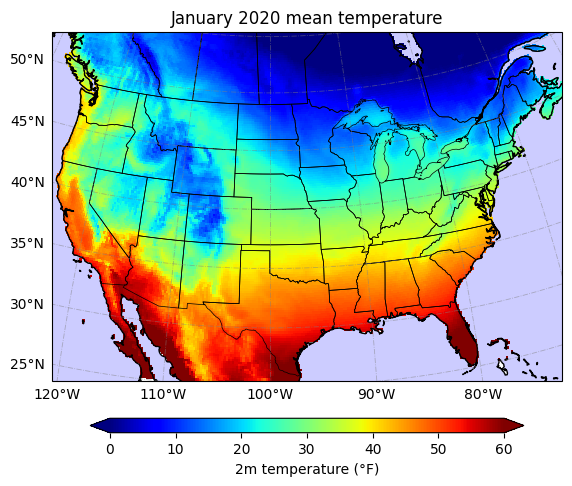

In [11]:
fig, axis = plt.subplots(1, 1,
    subplot_kw=dict(projection=cartopy.crs.Orthographic(-100, 34.5)),
    figsize=(5.8, 5))
plt.subplots_adjust(top=.94, bottom=0, left=.1, right=.98)
ds_jan.temperature_2m.plot(
    x='lon',
    y='lat',
    vmin=0,
    vmax=60,
    cmap='jet',
    ax=axis,
    transform=cartopy.crs.PlateCarree(),
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.85, # length of colorbar
        "pad": 0.08, # the distance between colorbar and the plot
        "aspect": 30, # the width (thickness) of colorbar
        "label": "2m temperature (°F)"
    },
    robust=True)
axis.coastlines()
axis.add_feature(cfeature.STATES, zorder=1, linewidth=.5, edgecolor='k')
axis.add_feature(cfeature.OCEAN, facecolor='b', alpha=.2)
gl = axis.gridlines(crs=cartopy.crs.PlateCarree(),
                    draw_labels=True,
                    linewidth=.6,
                    color='gray',
                    alpha=0.5,
                    linestyle='-.')
gl.top_labels = False  # suppress top labels
gl.right_labels = False  # suppress right labels
axis.set_extent([-120.5, -72, 23.6, 53], crs=cartopy.crs.PlateCarree())
plt.title('January 2020 mean temperature')
plt.savefig('Fig_t2m_199001.png', format='png', dpi=200)